In [23]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import joblib
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from feature_engine.imputation import (
    CategoricalImputer,
    AddMissingIndicator,
    MeanMedianImputer)

from feature_engine.encoding import (
    RareLabelEncoder,
    OneHotEncoder
)

## Importation of the data set

In [24]:
data = pd.read_csv(r'C:\Users\nico_\Desktop\mlops_udemy\Titanic\titanic.csv')

data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


In [25]:
data.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [26]:
# list of variables to be used in the pipeline's transformers

NUMERICAL_VARIABLES = ["Age", "Fare"]

CATEGORICAL_VARIABLES = ['Sex', 'Cabin', 'Embarked']

CABIN = ['Cabin']

## data into train and test

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('Survived', axis=1), 
    data['Survived'], 
    test_size=0.2, 
    random_state=0) 

X_train.shape, X_test.shape

((712, 8), (179, 8))

## Preprocessors

### Class to extract the letter from the variable Cabin

In [28]:
class ExtractLetterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        if not isinstance(variables, list):
            raise ValueError('variables should be a list')
        self.variables = variables
        
    def fit(self, X, y=None):
        # Cette méthode ne fait rien, elle est seulement présente pour respecter la signature de fit
        return self

    def transform(self, X):
        X = X.copy()
        for feature in self.variables:
            X[feature] = X[feature].str[0]
        return X


## Pipeline

- Impute categorical variables with string missing
- Add a binary missing indicator to numerical variables with missing data
- Fill NA in original numerical variable with the median
- Extract first letter from cabin
- Group rare Categories
- Perform One hot encoding
- Scale features with standard scaler
- Fit a Logistic regression

In [30]:
titanic_pipe = Pipeline([
    # === IMPUTATION ===
    ('categorical_imputation', CategoricalImputer(
        imputation_method='missing', variables=CATEGORICAL_VARIABLES)),
# Remplit les valeurs manquantes des variables catégorielles avec la chaîne 'missing'
    
    ('missing_indicator', AddMissingIndicator(variables=NUMERICAL_VARIABLES)),
# Ajoute une colonne binaire indiquant la présence de valeurs manquantes dans les variables numériques.
    
    ('median_imputation', MeanMedianImputer(
        imputation_method='median', variables=NUMERICAL_VARIABLES)),
# Remplace les valeurs manquantes des variables numériques par la médiane
    
    ('extract_letter', ExtractLetterTransformer(variables=CABIN)),
# Extrait la première lettre de chaque valeur de la variable 'Cabin' pour simplifier les catégories

    # === ENCODING ===

    ('rare_label_encoder', RareLabelEncoder(
        tol=0.05, n_categories=1, variables=CATEGORICAL_VARIABLES)),
# Traitement des variables catégorielles rares qui peuvent augmenté le bruit et diminuer la capacité
# du modèle à généraliser. Ici le seuil est fixé à 5%.
    
    ('categorical_encoder', OneHotEncoder(
        drop_last=True, variables=CATEGORICAL_VARIABLES)),
# encodage binaire, drop_last=True supprime la multicolinéarité en supprimant la dernière variable
        
    ('scaler', StandardScaler()),
# Standardisation  
    
    ('Logit', LogisticRegression()),
])

In [31]:
titanic_pipe.fit(X_train, y_train) 

Pipeline(steps=[('categorical_imputation',
                 CategoricalImputer(variables=['Sex', 'Cabin', 'Embarked'])),
                ('missing_indicator',
                 AddMissingIndicator(variables=['Age', 'Fare'])),
                ('median_imputation',
                 MeanMedianImputer(variables=['Age', 'Fare'])),
                ('extract_letter',
                 ExtractLetterTransformer(variables=['Cabin'])),
                ('rare_label_encoder',
                 RareLabelEncoder(n_categories=1,
                                  variables=['Sex', 'Cabin', 'Embarked'])),
                ('categorical_encoder',
                 OneHotEncoder(drop_last=True,
                               variables=['Sex', 'Cabin', 'Embarked'])),
                ('scaler', StandardScaler()), ('Logit', LogisticRegression())])

## predictions and evaluation of model performance

In [33]:
# prediction for train set
class_ = titanic_pipe.predict(X_train)
pred = titanic_pipe.predict_proba(X_train)[:,1]

# Score
print('train roc-auc: {}'.format(roc_auc_score(y_train, pred)))
print('train accuracy: {}'.format(accuracy_score(y_train, class_)))
print()

train roc-auc: 0.8607432810166296
train accuracy: 0.8061797752808989



In [36]:
fpr, tpr, thresholds = roc_curve(y_train, pred)

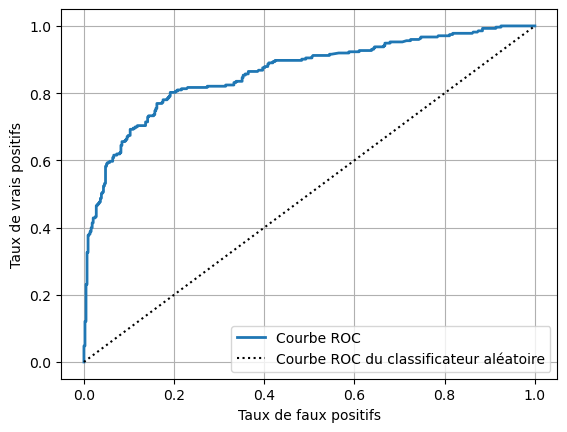

In [37]:
plt.plot(fpr,tpr,linewidth=2, label="Courbe ROC")
plt.plot([0,1], [0,1], "k:", label="Courbe ROC du classificateur aléatoire")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.legend()
plt.grid()
plt.show()

In [38]:
# predictions for test set
class_ = titanic_pipe.predict(X_test)
pred = titanic_pipe.predict_proba(X_test)[:,-1]

# Score
print('test roc-auc: {}'.format(roc_auc_score(y_test, pred)))
print('test accuracy: {}'.format(accuracy_score(y_test, class_)))
print()

test roc-auc: 0.8652173913043478
test accuracy: 0.8100558659217877



In [41]:
fpr, tpr, thresholds = roc_curve(y_test, pred)

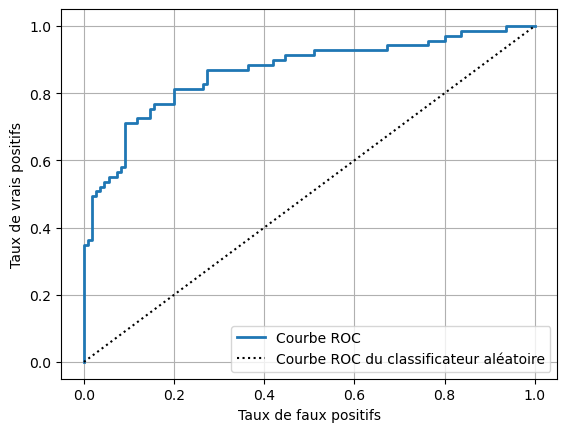

In [42]:
plt.plot(fpr,tpr,linewidth=2, label="Courbe ROC")
plt.plot([0,1], [0,1], "k:", label="Courbe ROC du classificateur aléatoire")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.legend()
plt.grid()
plt.show()